(min_ellipsoid:title)=
# Minimal Enclosing Ellipsoid

In this example, we consider a polytope given as the convex hull of \\(m\\) of data points,

$$
S = \text{conv}\left\{\pmb{x}_1, \pmb{x}_2, ..., \pmb{x}_m\right\}, ~~~\pmb{x}_i \in \mathbb{R}^n.
$$

The polytope is enclosed in the following ellipsoid

$$
\mathcal{E} := \left\{\pmb{x}\left|\|\pmb{Px} - \pmb{c}\|_2 \leq 1 \right.\right\},
$$

where $\pmb{P}$ and $\pmb{c}$ are the coefficients of the ellipsoid. According to [MOSEK Modeling Cookbook](https://docs.mosek.com/MOSEKModelingCookbook-letter.pdf), the minimum-volume enclosing ellipsoid can be achieved via solving the solving semidefinite programming problem.

$$
\begin{align}
\max~&\text{det}(\pmb{P}) \\
\text{s.t.}~&\|\pmb{Px}_i - \pmb{c}\|_2 \leq 1, &i=1, 2, ..., m \\
&\pmb{P} \succeq 0.
\end{align}
$$

The function \\(\text{det}(\cdot)\\) indicates the determinant of a given matrix, which is either convex or concave, but the logarithm of the determinant is concave, and maximizing $\log(\text{det}(\pmb{P}))$ can be approximated by the following conic programming problem:

$$
\begin{align}
\max~&\sum\limits_{i=1}^n v_i \\
\text{s.t.}~&v_i \leq \log(Z_{ii}), &i=1, 2, ..., n\\
&\left(
\begin{array}{cc}
\pmb{P} & \pmb{Z} \\
\pmb{Z} & \text{diag}(\pmb{Z})
\end{array}
\right) \succeq 0 \\
&\pmb{Z}\text{ if lower triangular}.
\end{align}
$$

Therefore, the minimum-volume enclosing ellipsoid problem can be rewritten as follows.

$$
\begin{align}
\max~&\sum\limits_{i=1}^n v_i \\
\text{s.t.}~&v_i \leq \log(Z_{ii}), &i=1, 2, ..., n\\
&\left(
\begin{array}{cc}
\pmb{P} & \pmb{Z} \\
\pmb{Z} & \text{diag}(\pmb{Z})
\end{array}
\right) \succeq 0 \\
&\|\pmb{Px}_i - \pmb{c}\|_2 \leq 1, &i=1, 2, ..., m \\
&\pmb{P} \succeq 0 \\
&\pmb{Z}\text{ if lower triangular}.
\end{align}
$$

In the following numerical experiments, the data points are randomly generated with \\(n=2\\) and \\(m=50\\) by the code segment below.

In [1]:
import numpy as np

n = 2
m = 50

np.random.seed(1)
xs = np.random.randn(m, n)
xs[:, 1] = xs[:, 0]*0.08 + xs[:, 1]

The Python code for implementing the model above is presented below.

In [2]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

model = ro.Model()

P = model.dvar((n, n))
c = model.dvar(n)
Z = rso.tril(model.dvar((n, n)))
v = model.dvar(n)

model.max(v.sum())
model.st(v <= rso.log(rso.diag(Z)))
model.st(rso.rstack([P, Z], 
                    [Z.T, rso.diag(Z, fill=True)]) >> 0)
for i in range(m):
    model.st(rso.norm(P@xs[i] - c) <= 1)
model.st(P >> 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0270s


The boundary of the ellipsoid is achieved by the following code using the solution of $\pmb{P}$ and $\pmb{c}$.

In [3]:
Ps = P.get()
cs = c.get()

step = 0.01
t = np.arange(0, 2*np.pi+step, step)
y = np.vstack((np.cos(t), np.sin(t))).T

ellip = np.linalg.inv(Ps) @ (y + cs).T

Finally, the enclosing ellipsoid and randomly generated data points are shown below. 

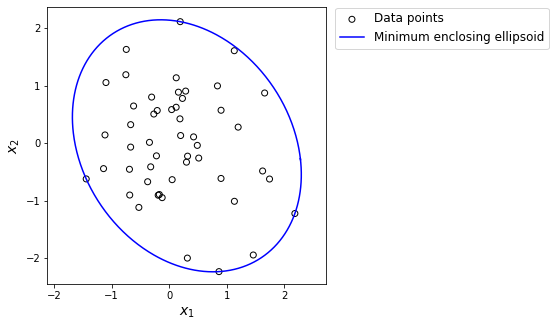

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(xs[:, 0], xs[:, 1], 
            marker='o', facecolor='none', color='k', label='Data points')
plt.plot(ellip[0], ellip[1], color='b', 
         label='Minimum enclosing ellipsoid')
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 1.02))
plt.axis('equal')
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)
plt.show()